Imports

In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from torchvision import datasets
from torchvision import transforms as T

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Defining functions

In [13]:
def get_data(data_dir, transform=None):
    data = datasets.ImageFolder(data_dir, transform=transform)
    return shuffle(data)


def get_k_fold_data(k, i, dataset):
    assert k > 1

    k_size = int(len(dataset) / k)
    train_ids = list(range(k_size * i)) + list(range(k_size * (i + 1), len(dataset)))
    valid_ids = range(k_size * i, k_size * (i + 1))

    train_set = Subset(dataset, train_ids)
    valid_set = Subset(dataset, valid_ids)

    return train_set, valid_set


def get_net():
    input_size = 320 * 240 * 3
    net = nn.Sequential(
        nn.Linear(input_size, 2048),
        nn.ReLU(),
        nn.Dropout(.4),
        nn.Linear(2048, 3072),
        nn.ReLU(),
        nn.Dropout(.4),
        nn.Linear(3072, 2048),
        nn.ReLU(),
        nn.Dropout(.4),
        nn.Linear(2048, 1024),
        nn.ReLU(),
        nn.Dropout(.2),
        nn.Linear(1024, 256),
        nn.ReLU(),
        nn.Dropout(.2),
        nn.Linear(256, 5),
        nn.LogSoftmax(dim=1)
    )

    if torch.cuda.is_available():
        net.cuda()
        print('using gpu\n\n')
    else:
        print('no gpu\n\n')

    return net


def train(net, train_iter, valid_iter, loss, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, valid_ls = [], []
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        train_l_epoch, valid_l_epoch = [], []

        # train
        for X, y in train_iter:
            X = X.cuda()
            y = y.cuda()

            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            train_l_epoch.append(l.item())
        train_ls.append(sum(train_l_epoch) / len(train_l_epoch))
        
        # validation
        with torch.no_grad():
            for X, y in valid_iter:
                X = X.cuda()
                y = y.cuda()
                valid_l_epoch.append(loss(net(X), y).item())
        valid_ls.append(sum(valid_l_epoch) / len(valid_l_epoch))

        if (epoch + 1) % (num_epochs // 5) == 0:
            print(f'e: {epoch + 1}\ttrain loss: {train_ls[-1]:.4f}\tvalid loss: {valid_ls[-1]:.4f}')
    
    return train_ls, valid_ls


def k_fold(k, dataset, num_epochs, learning_rate, weight_decay, batch_size):
    train_l, valid_l = [], []
    net = get_net()
    loss = nn.CrossEntropyLoss()
    for i in range(k):
        print('k:', i + 1)
        train_set, valid_set = get_k_fold_data(k, i, dataset)
        train_iter = DataLoader(train_set, batch_size=batch_size)
        valid_iter = DataLoader(valid_set, batch_size=batch_size)

        k_train_ls, k_valid_ls = train(net, train_iter, valid_iter, loss, num_epochs, learning_rate, weight_decay, batch_size)

        train_l += k_train_ls
        valid_l += k_valid_ls

    plot_loss_graph(train_l, valid_l)
    return sum(train_l) / (k * num_epochs), sum(valid_l) / (k * num_epochs)


def plot_loss_graph(train_l, valid_l):
    _, ax = plt.subplots()

    ax.plot(train_l, label='train')
    ax.plot(valid_l, label='validation')
    ax.set(xlabel='epoch', ylabel='sgd loss', title='Loss over epochs')
    ax.legend()

    plt.show()


Getting the data

In [4]:
DATA_DIR = '/content/drive/MyDrive/colab-stuff/flower-classifier/data'

transform = T.Compose([
    T.Resize((320, 240)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    T.Lambda(lambda x: torch.flatten(x))
])
dataset = get_data(DATA_DIR, transform)

Training

using gpu


k: 1
e: 1	train loss: 1.6064	valid loss: 1.6049
e: 2	train loss: 1.6042	valid loss: 1.6021
e: 3	train loss: 1.6007	valid loss: 1.5991
e: 4	train loss: 1.5980	valid loss: 1.5968
e: 5	train loss: 1.5950	valid loss: 1.5934
e: 6	train loss: 1.5916	valid loss: 1.5896
e: 7	train loss: 1.5900	valid loss: 1.5872
e: 8	train loss: 1.5850	valid loss: 1.5826
e: 9	train loss: 1.5821	valid loss: 1.5790
e: 10	train loss: 1.5755	valid loss: 1.5753
e: 11	train loss: 1.5717	valid loss: 1.5710
e: 12	train loss: 1.5653	valid loss: 1.5620
e: 13	train loss: 1.5565	valid loss: 1.5543
e: 14	train loss: 1.5455	valid loss: 1.5382
e: 15	train loss: 1.5343	valid loss: 1.5234
e: 16	train loss: 1.5164	valid loss: 1.5113
e: 17	train loss: 1.4917	valid loss: 1.4859
e: 18	train loss: 1.4664	valid loss: 1.4602
e: 19	train loss: 1.4443	valid loss: 1.4241
e: 20	train loss: 1.4145	valid loss: 1.4009
e: 21	train loss: 1.3906	valid loss: 1.3853
e: 22	train loss: 1.3594	valid loss: 1.3527
e: 23	train loss: 1.3319

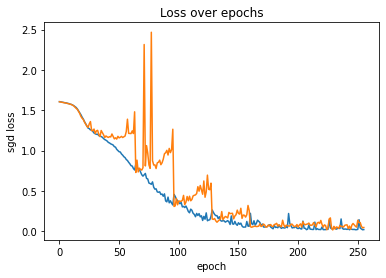

In [11]:
k, num_epochs, lr, weight_decay, batch_size = 8, 32, .003, .001, 64
train_l, valid_l = k_fold(k, dataset, num_epochs, lr, weight_decay, batch_size)